In [84]:
import urllib
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
 
# METHOD #1: OpenCV, NumPy, and urllib
def url_to_image(url):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    try:
        resp = urllib.request.urlopen(url)
        image = np.asarray(bytearray(resp.read()), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        return image
    except:
        return None

In [66]:
data_info = {}
with open("IMDb-Face.csv", "r", encoding="utf8") as f:
    reader = csv.reader(f, delimiter=",")
    for i, line in tqdm(enumerate(reader)):
        if line[0] in data_info:
            data_info[line[0]] += 1
        else:
            data_info[line[0]] = 1

In [75]:
len(data_info)

59305

In [76]:
max(data_info.values())

10455

(array([1., 1., 0., ..., 0., 0., 1.]),
 array([    1,     2,     3, ..., 10453, 10454, 10455]),
 <a list of 10454 Patch objects>)

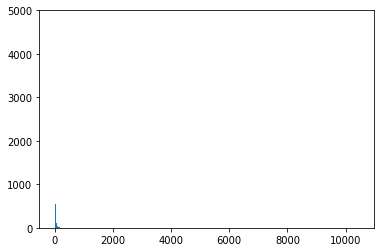

In [79]:
data = list(data_info.values())
plt.hist(data, bins=np.arange(min(data), max(data)+1))

In [82]:
freq = {}
for key in data_info:
    value = data_info[key]
    if value in freq:
        freq[value] += 1
    else:
        freq[value] = 1
        

In [119]:
celebs = [key for key in data_info if data_info[key]>150]
len(celebs)

1061

In [121]:
celebs = celebs[:10]

In [123]:
import csv
import cv2
import os
import numpy as np
from tqdm import tqdm_notebook as tqdm

output_dir="./images/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

num_imgs = 10 #number of images per celeb
done = {}


with open("IMDb-Face.csv", "r", encoding="utf8") as f:
    reader = csv.reader(f, delimiter=",")
    for i, line in tqdm(enumerate(reader), total=num_imgs):
        if i==0:
            continue
        celeb_name = line[0]
        
        if celeb_name not in celebs:
            continue
            
        if celeb_name not in done:
            done[celeb_name] = 0
            
        if done[celeb_name]==num_imgs:
            continue

        faces_img_dir = os.path.join(output_dir, "Faces", celeb_name)
        full_img_dir = os.path.join(output_dir,"Full", celeb_name)
        if not os.path.exists(faces_img_dir):
            os.makedirs(faces_img_dir)
        if not os.path.exists(full_img_dir):
            os.makedirs(full_img_dir)

        size = [int(x) for x in line[4].split()]
        bounds = [int(x) for x in line[3].split()]
        url = line[5]
        image = url_to_image(url)
        if image is not None:
            image = cv2.resize(image, (size[1], size[0]))
            image = image[:,:,::-1]
            try:
                plt.imsave(os.path.join(full_img_dir, line[2]), image)
                image = image[bounds[1]:bounds[3],bounds[0]:bounds[2],:]
                plt.imsave(os.path.join(faces_img_dir, line[2]), image)
                done[celeb_name] += 1
            except:
                pass